In [1]:
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:

video_data = os.listdir('..\\data_scraping\\Web_Scrape_Labeled_2\\')
# print(video_data)

o_counter = 0
f_counter = 0
b_counter = 0
s_counter = 0
l_counter = 0

left_counter = 0
NUM_FILES = 207

for filename in video_data:
    o_counter += int(filename[4])
    f_counter += int(filename[7])
    b_counter += int(filename[10])
    s_counter += int(filename[13])
    l_counter += int(filename[16])
    if (filename[18] == 'L'): 
        left_counter += 1

left_counter = float(left_counter) / (float(NUM_FILES))
left_counter *= 100


L entrances: 61.836%
R entrances: 38.164%

Sums of all ratings: 
overstride: 477
forward lean: 172
backward lean: 414
sweeping: 997
low arms: 257


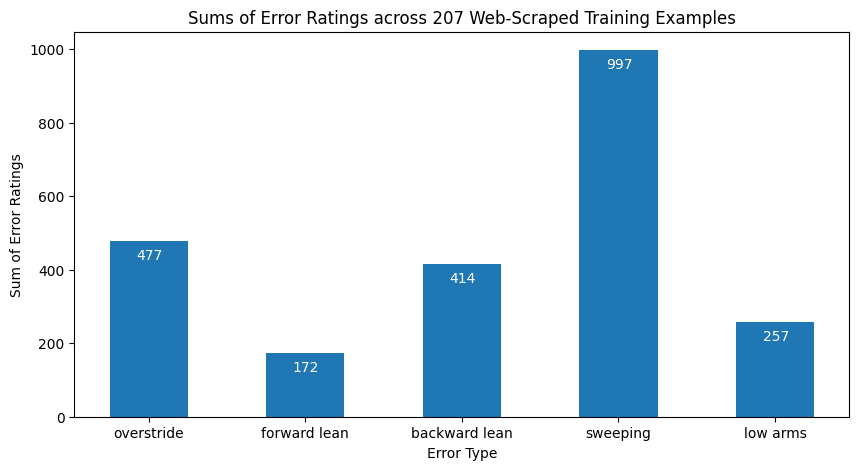

In [4]:
print('L entrances: ' + str(round(left_counter, 3)) + '%')
print('R entrances: ' + str(round(100 - left_counter, 3)) + '%\n')

print('Sums of all ratings: ')
print('overstride: ' + str(o_counter))
print('forward lean: ' + str(f_counter))
print('backward lean: ' + str(b_counter))
print('sweeping: ' + str(s_counter))
print('low arms: ' + str(l_counter))

errors = ['overstride', 'forward lean', 'backward lean', 'sweeping', 'low arms']
rating_sums = [o_counter, f_counter, b_counter, s_counter, l_counter]

fig = plt.figure(figsize=(10, 5))

plt.bar(errors, rating_sums, width = 0.5)
plt.xlabel('Error Type')
plt.ylabel('Sum of Error Ratings')
plt.title('Sums of Error Ratings across 207 Web-Scraped Training Examples')    

for index, value in enumerate(rating_sums):
    plt.text(index - 0.08, value -50, str(value), color='white') # add annotations

plt.show()

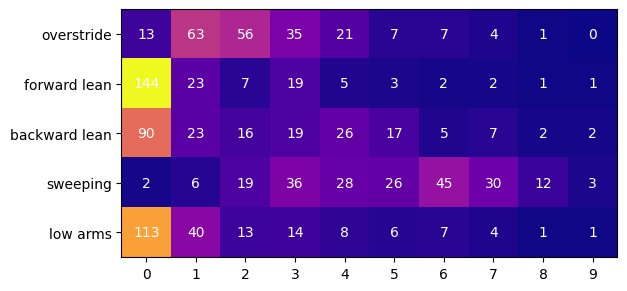

In [5]:
ratings = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

type_count = np.zeros((5, 10), dtype=int)

for filename in video_data:
    type_count[0][int(filename[4])] += 1
    type_count[1][int(filename[7])] += 1
    type_count[2][int(filename[10])] += 1
    type_count[3][int(filename[13])] += 1
    type_count[4][int(filename[16])] += 1

# print(type_count)

fig, ax = plt.subplots()
im = ax.imshow(type_count, cmap='plasma')

ax.set_xticks(np.arange(len(ratings)))
ax.set_yticks(np.arange(len(errors)))
ax.set_xticklabels(ratings)
ax.set_yticklabels(errors)

for i in range(len(errors)):
    for j in range(len(ratings)):
        text = ax.text(j, i, type_count[i, j], ha="center", va="center", color="white")

plt.show()